<a href="https://colab.research.google.com/github/MangoHaha/SentimentAnalysis/blob/investigate_new_Arch/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General information

In this kernel I'll work with data from Movie Review Sentiment Analysis Playground Competition.


In [25]:
!pip install lightgbm wordcloud
!pip install pydot && apt-get install graphviz


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
pd.set_option('max_colwidth',400)
from google.colab import drive
import nltk
nltk.download('stopwords')
from google.colab import files


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import dataset are stored inside my google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Read dataset: train test submission

In [0]:
train = pd.read_csv('/content/drive/My Drive/DeepLearning/train.tsv', sep="\t")
test = pd.read_csv('/content/drive/My Drive/DeepLearning/test.tsv', sep="\t")
sub = pd.read_csv('/content/drive/My Drive/DeepLearning/sampleSubmission.csv', sep=",")
y = train['Sentiment']

This dataset is interesting for NLP researching. Sentences from original dataset were split in separate phrases and each of them has a sentiment label. Also a lot of phrases are really short which makes classifying them quite challenging.
We can see than sentences were split in 18-20 phrases at average and a lot of phrases contain each other. Sometimes one word or even one punctuation mark influences the sentiment

In [31]:
#print(train.head(10))
print(train.loc[train.SentenceId == 20])
print('Average count of phrases per sentence in train is {0:.0f}.'.format(train.groupby('SentenceId')['Phrase'].count().mean()))
print('Average count of phrases per sentence in test is {0:.0f}.'.format(test.groupby('SentenceId')['Phrase'].count().mean()))
print('Number of phrases in train: {}. Number of sentences in train: {}.'.format(train.shape[0], len(train.SentenceId.unique())))
print('Number of phrases in test: {}. Number of sentences in test: {}.'.format(test.shape[0], len(test.SentenceId.unique())))
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(train['Phrase'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['Phrase'].apply(lambda x: len(x.split())))))

     PhraseId  SentenceId  \
536       537          20   
537       538          20   
538       539          20   
539       540          20   
540       541          20   
541       542          20   
542       543          20   
543       544          20   
544       545          20   
545       546          20   
546       547          20   
547       548          20   
548       549          20   
549       550          20   
550       551          20   

                                                   Phrase  Sentiment  
536  It 's everything you 'd expect -- but nothing more .          2  
537     's everything you 'd expect -- but nothing more .          1  
538       's everything you 'd expect -- but nothing more          2  
539          everything you 'd expect -- but nothing more          1  
540                                            everything          2  
541                     you 'd expect -- but nothing more          1  
542                         'd expect 

On Overlapping sentences in both Train and Test set

In [0]:
save_test = pd.merge(test, train[["Phrase", "Sentiment"]], on="Phrase", how="inner")
print ("Number of overlapping phrases  ", save_test.shape[0])
print ("% of neutral sentiment phrases",save_test[(save_test['Sentiment'] == 2)].count()[0] /save_test.shape[0])
save_test = save_test[save_test["Sentiment"].notnull()]
save_test.drop(['SentenceId', 'Phrase'], axis=1,inplace=True)
save_test = save_test[save_test["Sentiment"].notnull()]

import math
def get_sentiment(row):
    old_s = row['Sentiment_x']
    new_s = row['Sentiment_y']
    if math.isnan(new_s):
        return int(old_s)
    else:
        return int(new_s)

### Thoughts on feature processing and engineering

So, we have only phrases as data. And a phrase can contain a single word. And one punctuation mark can cause phrase to receive a different sentiment. Also assigned sentiments can be strange. This means several things:
- using stopwords can be a bad idea, especially when phrases contain one single stopword;
- puntuation could be important, so it should be used;
- ngrams are necessary to get the most info from data;
- using features like word count or sentence length won't be useful;

## Models

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, LeakyReLU
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [0]:
embedding_path = "/content/drive/My Drive/DeepLearning/crawl-300d-2M.vec"
#embedding_path = "/content/drive/My Drive/DeepLearning/glove.twitter.27B.25d.txt"
#embed_size = 25
embed_size = 300
max_features = 30000

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
tk = Tokenizer(lower = True, filters='')
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
tk.fit_on_texts(full_text)
train_tokenized = tk.texts_to_sequences(train['Phrase'])
test_tokenized = tk.texts_to_sequences(test['Phrase'])

In [0]:
max_len = 50
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))
ohe.fit(train["Sentiment"].values.reshape(-1, 1))

###Model 1

An attempt at ensemble:

In [0]:
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    inp = Input(shape = (max_len,))
    x = Embedding(19479, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    return model

Print the Summary and Arch of the model

In [16]:
trained_model1.summary()
SVG(model_to_dot(trained_model1,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      5843700     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 128)      140544      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
bidirectio

K folds Validation

In [24]:
NUM_FOLDS = 5
train["fold_id"] = train["SentenceId"].apply(lambda x: x%NUM_FOLDS)
test_preds = np.zeros((test.shape[0], 5))
file_path = "/content/drive/My Drive/DeepLearning/best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 2)

print("Building the model...")
model1 = build_model1(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

for i in range(NUM_FOLDS):
    print("FOLD", i+1)    
    print("Splitting the data into train and validation...")
    train_seq, val_seq = X_train[train["fold_id"] != i], X_train[train["fold_id"] == i]
    y_train = ohe.transform(train[train["fold_id"] != i]["Sentiment"].values.reshape(-1, 1))
    y_val = ohe.transform(train[train["fold_id"] == i]["Sentiment"].values.reshape(-1, 1))        
    
    print("Training the model...")
    model1.fit(train_seq, y_train, validation_data = (val_seq, y_val), batch_size = 128, epochs = 15, verbose = 1, callbacks = [early_stop]) 
    model1.save_weights(file_path)  
    test_preds += model1.predict([X_test], batch_size=1024, verbose=1)    
    print()
    
print("Save model after cross-validation...")
model1.save_weights(file_path)   
test_preds /= NUM_FOLDS


print("Make the submission ready...")
sub = pd.read_csv('/content/drive/My Drive/DeepLearning/sampleSubmission.csv', sep=",")

pred = model1.predict(X_test, batch_size = 1024, verbose = 1)
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
submission = pd.DataFrame({'PhraseId':test['PhraseId'],'Sentiment': predictions})
submission =pd.merge(submission, save_test, on='PhraseId', how='left')
submission["Sentiment"] = submission.apply(get_sentiment, axis=1)
submission.drop(['Sentiment_x', 'Sentiment_y'], axis=1,inplace=True)
submission["Sentiment"] = submission["Sentiment"].astype(int)
submission.to_csv("/content/drive/My Drive/DeepLearning/blend.csv", index=False)

predictions = np.round(np.argmax(test_preds, axis=1)).astype(int)
submission = pd.DataFrame({'PhraseId':test['PhraseId'],'Sentiment': predictions})
submission =pd.merge(submission, save_test, on='PhraseId', how='left')
submission["Sentiment"] = submission.apply(get_sentiment, axis=1)
submission.drop(['Sentiment_x', 'Sentiment_y'], axis=1,inplace=True)
submission["Sentiment"] = submission["Sentiment"].astype(int)
submission.to_csv("/content/drive/My Drive/DeepLearning/avg_blend.csv", index=False)

Building the model...
FOLD 1
Splitting the data into train and validation...
Training the model...
Train on 125230 samples, validate on 30830 samples
Epoch 1/15
125230/125230 [==============================] - 70s 557us/step - loss: 0.3728 - acc: 0.8319 - val_loss: 0.3122 - val_acc: 0.8580
Epoch 2/15
125230/125230 [==============================] - 62s 493us/step - loss: 0.3281 - acc: 0.8515 - val_loss: 0.3031 - val_acc: 0.8599
Epoch 3/15
125230/125230 [==============================] - 62s 492us/step - loss: 0.3184 - acc: 0.8549 - val_loss: 0.3007 - val_acc: 0.8629
Epoch 4/15
125230/125230 [==============================] - 62s 494us/step - loss: 0.3115 - acc: 0.8572 - val_loss: 0.2998 - val_acc: 0.8620
Epoch 5/15
125230/125230 [==============================] - 62s 493us/step - loss: 0.3046 - acc: 0.8599 - val_loss: 0.2952 - val_acc: 0.8663
Epoch 6/15
125230/125230 [==============================] - 62s 493us/step - loss: 0.2976 - acc: 0.8632 - val_loss: 0.2900 - val_acc: 0.8669
Epoc

Print the Arch of trained model

In [0]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    inp = Input(shape = (max_len,))
    x = Embedding(19479, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(128, kernel_size=kernel_size1, padding='causal', kernel_initializer='he_uniform')(x_gru)
    x_conv1 = Conv1D(64, kernel_size=kernel_size1, padding='causal', kernel_initializer='he_uniform')(x_conv1)
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='causal', kernel_initializer='he_uniform')(x_conv1)

      
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(128, kernel_size=kernel_size2, padding='causal', kernel_initializer='he_uniform')(x_gru)
    x_conv2 = Conv1D(64, kernel_size=kernel_size2, padding='causal', kernel_initializer='he_uniform')(x_conv2)
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='causal', kernel_initializer='he_uniform')(x_conv2)    
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(128, kernel_size=kernel_size1, padding='causal', kernel_initializer='he_uniform')(x_lstm)
    x_conv3 = Conv1D(64, kernel_size=kernel_size1, padding='causal', kernel_initializer='he_uniform')(x_conv3)
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='causal', kernel_initializer='he_uniform')(x_conv3)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(128, kernel_size=kernel_size2, padding='causal', kernel_initializer='he_uniform')(x_lstm)
    x_conv4 = Conv1D(64, kernel_size=kernel_size2, padding='causal', kernel_initializer='he_uniform')(x_conv4)
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='causal', kernel_initializer='he_uniform')(x_conv4)

    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      5843700     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 50, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 50, 128)      140544      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
bidirectio

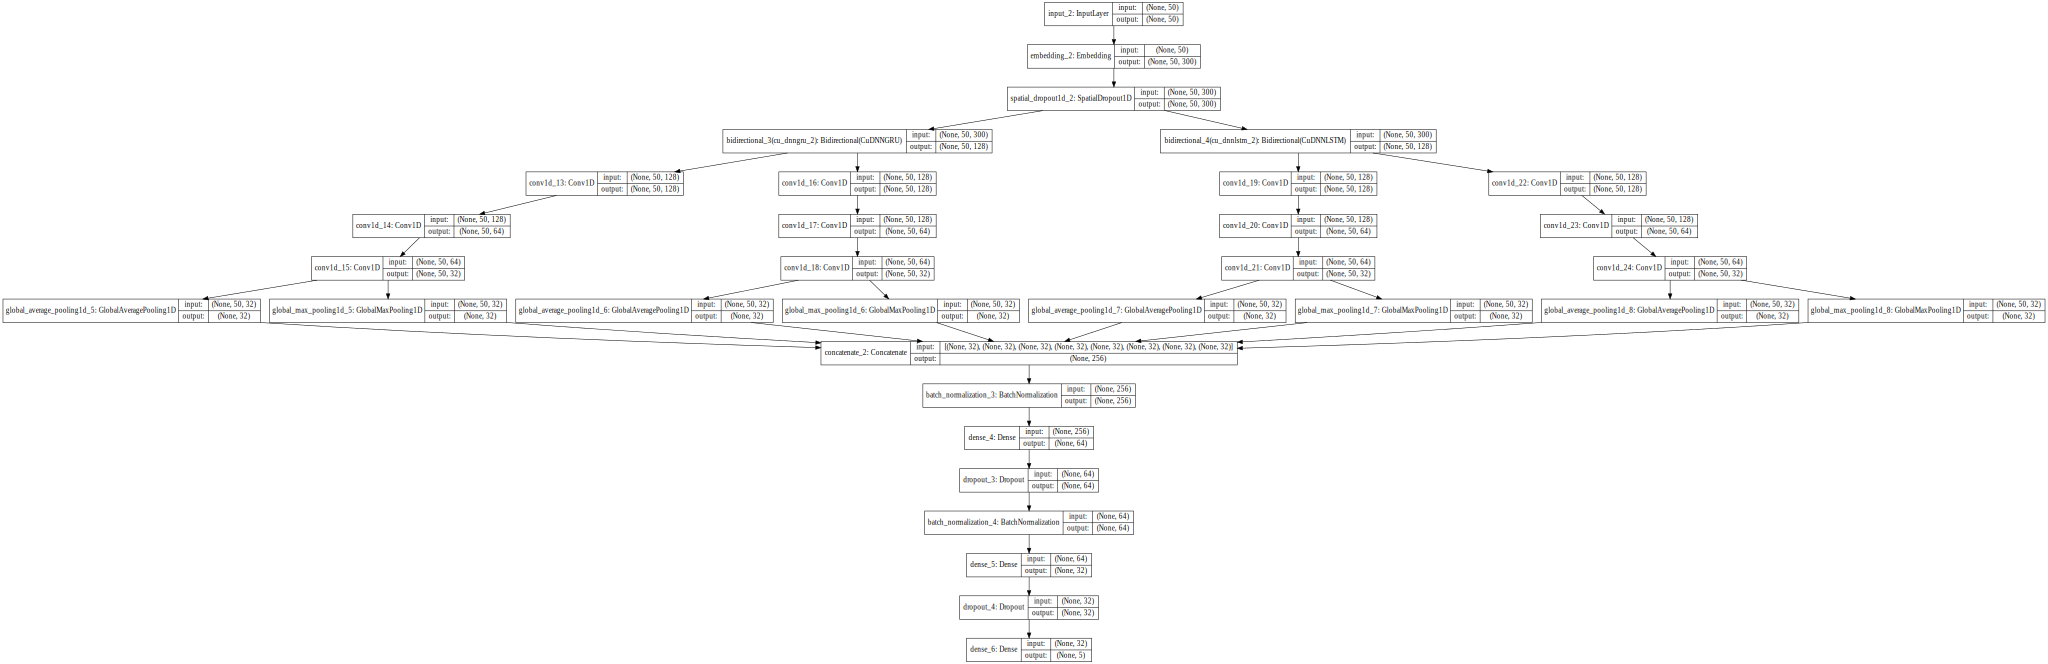

In [15]:
trained_model2 = build_model2(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)
trained_model2.summary()
SVG(model_to_dot(trained_model2,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [39]:
test_preds = np.zeros((test.shape[0], 5))
file_path = "/content/drive/My Drive/DeepLearning/best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 2)

print("Building the model...")
model2 = build_model2(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

for i in range(NUM_FOLDS):
    print("FOLD", i+1)    
    print("Splitting the data into train and validation...")
    train_seq, val_seq = X_train[train["fold_id"] != i], X_train[train["fold_id"] == i]
    y_train = ohe.transform(train[train["fold_id"] != i]["Sentiment"].values.reshape(-1, 1))
    y_val = ohe.transform(train[train["fold_id"] == i]["Sentiment"].values.reshape(-1, 1))        
    
    print("Training the model...")
    model2.fit(train_seq, y_train, validation_data = (val_seq, y_val), batch_size = 128, epochs = 15, verbose = 1, callbacks = [early_stop]) 
    model2.save_weights(file_path)  
    test_preds += model2.predict([X_test], batch_size=1024, verbose=1)    
    print()
    
print("Save model after cross-validation...")
model2.save_weights(file_path)   
test_preds /= NUM_FOLDS


print("Make the submission ready...")
sub = pd.read_csv('/content/drive/My Drive/DeepLearning/sampleSubmission.csv', sep=",")

pred = model2.predict(X_test, batch_size = 1024, verbose = 1)
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub['Sentiment'] = predictions
sub.to_csv("/content/drive/My Drive/DeepLearning/blend.csv", index=False)

predictions = np.round(np.argmax(test_preds, axis=1)).astype(int)
sub['Sentiment'] = predictions
sub.to_csv("/content/drive/My Drive/DeepLearning/avg_blend.csv", index=False)

Building the model...
FOLD 1
Splitting the data into train and validation...
Training the model...
Train on 125230 samples, validate on 30830 samples
Epoch 1/15
125230/125230 [==============================] - 88s 703us/step - loss: 0.3736 - acc: 0.8326 - val_loss: 0.3258 - val_acc: 0.8490
Epoch 2/15
125230/125230 [==============================] - 79s 633us/step - loss: 0.3305 - acc: 0.8505 - val_loss: 0.3067 - val_acc: 0.8609
Epoch 3/15
125230/125230 [==============================] - 79s 634us/step - loss: 0.3202 - acc: 0.8535 - val_loss: 0.3108 - val_acc: 0.8611
Epoch 4/15
125230/125230 [==============================] - 80s 635us/step - loss: 0.3128 - acc: 0.8570 - val_loss: 0.3009 - val_acc: 0.8625
Epoch 5/15
125230/125230 [==============================] - 79s 633us/step - loss: 0.3062 - acc: 0.8598 - val_loss: 0.3019 - val_acc: 0.8654
Epoch 6/15
125230/125230 [==============================] - 79s 632us/step - loss: 0.3013 - acc: 0.8615 - val_loss: 0.2953 - val_acc: 0.8645
Epoc

###Model3 
LSTM + DCNN
loss: 0.7205 - acc: 0.6998 - val_loss: 0.6625 - val_acc: 0.7189

In [0]:
def build_model3(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    input_words = Input((max_len, ))
    x_words = Embedding(19479, embed_size,weights=[embedding_matrix],trainable=False)(input_words)
    x_words = SpatialDropout1D(0.3)(x_words)
    x_words = Bidirectional(CuDNNLSTM(50, return_sequences=True))(x_words)
    x_words = Dropout(0.2)(x_words)
    x_words = Conv1D(256, 3, strides = 1,  padding='causal', activation='relu', )(x_words)
    x_words = Conv1D(128, 3, strides = 1,  padding='causal', activation='relu', )(x_words)
    x_words = Conv1D(64, 3, strides = 1,   padding='causal', activation='relu', )(x_words)
    x_words = GlobalMaxPool1D()(x_words)
    x_words = Dropout(0.2)(x_words)

    x = Dense(50, activation="relu")(x_words)
    x = Dropout(0.2)(x)
    predictions = Dense(5, activation="softmax")(x)

    model = Model(inputs=[input_words], outputs=predictions)
    model.compile(optimizer='nadam' ,loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
model3 = build_model3(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

history = model.fit([X_train_words], X_train_target_binary, epochs=nb_epoch, verbose=1, batch_size = 1024, callbacks=[early_stop], validation_split = 0.2, shuffle=True)
history = model3.fit(train_seq, y_train, validation_data = (val_seq, y_val), batch_size = 128, epochs = 15, verbose = 1, callbacks = [early_stop]) 
train_loss = np.mean(history.history['loss'])
val_loss = np.mean(history.history['val_loss'])
print('Train loss: %f' % (train_loss*100))
print('Validation loss: %f' % (val_loss*100))

NameError: ignored

In [14]:
test_preds = np.zeros((test.shape[0], 5))
file_path = "/content/drive/My Drive/DeepLearning/best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode="min", patience = 3, verbose=1)

print("Building the model...")
model3 = build_model3(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

for i in range(NUM_FOLDS):
    print("FOLD", i+1)    
    print("Splitting the data into train and validation...")
    train_seq, val_seq = X_train[train["fold_id"] != i], X_train[train["fold_id"] == i]
    y_train = ohe.transform(train[train["fold_id"] != i]["Sentiment"].values.reshape(-1, 1))
    y_val = ohe.transform(train[train["fold_id"] == i]["Sentiment"].values.reshape(-1, 1))        
    
    print("Training the model...")
    model3.fit(train_seq, y_train, validation_data = (val_seq, y_val), batch_size = 128, epochs = 15, verbose = 1, callbacks = [early_stop]) 
    model3.save_weights(file_path)  
    test_preds += model3.predict([X_test], batch_size=1024, verbose=1)    
    print()
    
print("Save model after cross-validation...")
model3.save_weights(file_path)   
test_preds /= NUM_FOLDS


print("Make the submission ready...")
sub = pd.read_csv('/content/drive/My Drive/DeepLearning/sampleSubmission.csv', sep=",")

pred = model3.predict(X_test, batch_size = 1024, verbose = 1)
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub['Sentiment'] = predictions
sub.to_csv("/content/drive/My Drive/DeepLearning/blend.csv", index=False)

predictions = np.round(np.argmax(test_preds, axis=1)).astype(int)
sub['Sentiment'] = predictions
sub.to_csv("/content/drive/My Drive/DeepLearning/avg_blend.csv", index=False)

Building the model...
FOLD 1
Splitting the data into train and validation...
Training the model...
Train on 125230 samples, validate on 30830 samples
Epoch 1/15
125230/125230 [==============================] - 46s 366us/step - loss: 0.9709 - acc: 0.5990 - val_loss: 0.8935 - val_acc: 0.6251
Epoch 2/15
125230/125230 [==============================] - 40s 322us/step - loss: 0.8800 - acc: 0.6357 - val_loss: 0.8489 - val_acc: 0.6488
Epoch 3/15
125230/125230 [==============================] - 40s 321us/step - loss: 0.8414 - acc: 0.6511 - val_loss: 0.8371 - val_acc: 0.6549
Epoch 4/15
125230/125230 [==============================] - 40s 321us/step - loss: 0.8159 - acc: 0.6616 - val_loss: 0.8279 - val_acc: 0.6561
Epoch 5/15
125230/125230 [==============================] - 40s 321us/step - loss: 0.7955 - acc: 0.6676 - val_loss: 0.8275 - val_acc: 0.6587
Epoch 6/15
125230/125230 [==============================] - 40s 322us/step - loss: 0.7816 - acc: 0.6741 - val_loss: 0.8235 - val_acc: 0.6600
Epoc